In [1]:
pip install pandas scikit-learn joblib xlrd==2.0.1 openpyxl flask

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd

df = pd.read_excel('default of credit card clients.xls')
df.to_csv('default_of_credit_card_clients.csv', index=False)

print("Converted successfully!")


Converted successfully!


# Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [4]:
df = pd.read_csv('default_of_credit_card_clients.csv', header=1)
df.drop(columns=['ID'], inplace=True)

In [5]:
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (30000, 24)
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default 

# Data Cleaning & Feature Engineering

In [6]:
# Fix anomalies
df['EDUCATION'] = df['EDUCATION'].replace([0,5,6], 4)
df['MARRIAGE'] = df['MARRIAGE'].replace(0,3)

# Encode categorical variables
df['SEX'] = df['SEX'].map({1:0, 2:1})  # 0=Male,1=Female
df['EDUCATION'] = df['EDUCATION'].map({1:0,2:1,3:2,4:3})
df['MARRIAGE'] = df['MARRIAGE'].map({1:0,2:1,3:2})

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)

# Feature Engineering: 10 additional features
df['avg_bill'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)
df['avg_pay'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].mean(axis=1)
df['debt_ratio'] = df['avg_bill'] / df['LIMIT_BAL']
df['payment_ratio'] = df['avg_pay'] / (df['avg_bill'] + 1e-5)
df['max_delay'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)
df['min_delay'] = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].min(axis=1)
df['total_pay_amt'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].sum(axis=1)
df['total_bill_amt'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1)
df['bill_variation'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].std(axis=1)
df['pay_variation'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].std(axis=1)


# Feature Selection

In [7]:
X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

# Feature Scaling

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train Model

In [11]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=42)
lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=10, class_weight='balanced', random_state=42)

ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('lgb', lgb_model)],
    voting='soft'
)

ensemble_model.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8258
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('lgb',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.05, max_depth=10,
                                             n_estimators=500,
                                             random_state=42))],
                 voting='soft')

# Model Evaluation

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.805
ROC-AUC: 0.7687554295056451
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      4673
           1       0.57      0.46      0.51      1327

    accuracy                           0.81      6000
   macro avg       0.71      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000



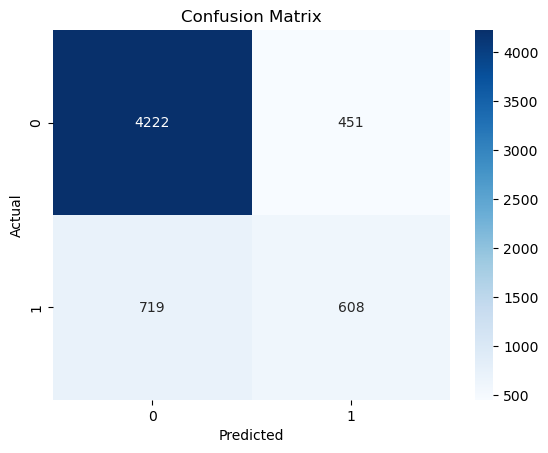

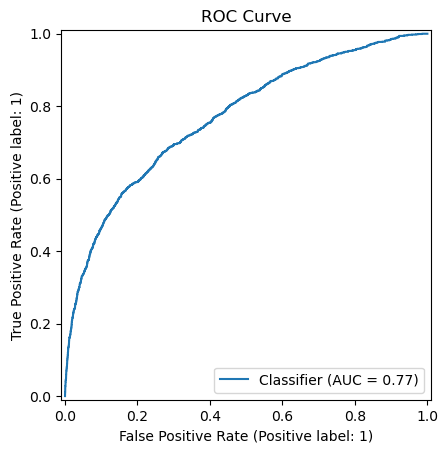

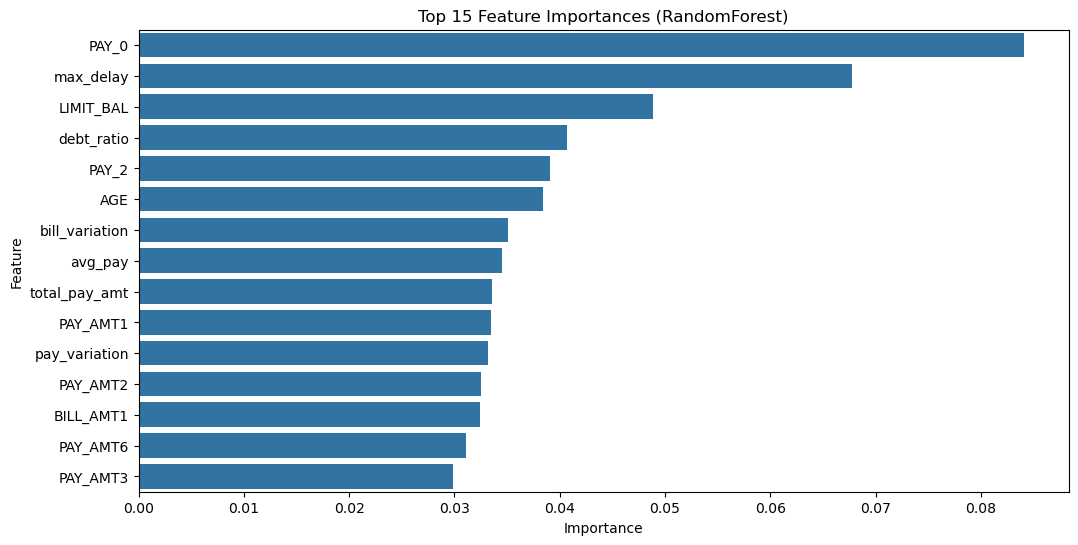

In [12]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# Convert X_test back to DataFrame for LightGBM
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Predictions
y_pred = ensemble_model.predict(X_test_df)
y_prob = ensemble_model.predict_proba(X_test_df)[:, 1]

# Accuracy & ROC
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.show()

# Feature Importances from RandomForest inside ensemble
rf_fitted = ensemble_model.named_estimators_['rf']
importances = rf_fitted.feature_importances_

feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title("Top 15 Feature Importances (RandomForest)")
plt.show()

# Save Model

In [13]:
joblib.dump(ensemble_model, 'creditworthiness_model.pkl')
joblib.dump(scaler, 'creditworthiness_model_scaler.pkl')
print("Model and scaler saved!")

Model and scaler saved!


In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.805


In [15]:
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      4673
           1       0.57      0.46      0.51      1327

    accuracy                           0.81      6000
   macro avg       0.71      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000



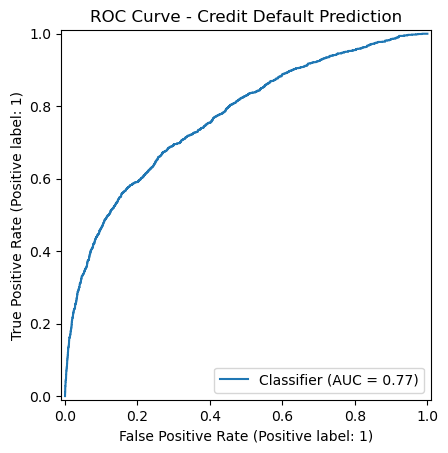

ROC-AUC Score: 0.7688


In [16]:
from sklearn.metrics import RocCurveDisplay

# =========================================
# ROC Curve on Test Set
# =========================================
y_prob = ensemble_model.predict_proba(X_test)[:, 1]

# Using sklearn's RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Credit Default Prediction")
plt.show()

# Optional: Compute AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

